In [1]:
def clip(tmp1):
    import subprocess
    import shlex  # 导入 shlex 模块
    # 使用 shlex.quote 来转义 inp 字符串
    tmp2 = str(tmp1)
    safe_str = shlex.quote(tmp2)
    subprocess.run('echo {} | wclip'.format(safe_str), shell=True)  

def cvin(k):
    clip(In[k])
    
import numpy as np
import matplotlib.pyplot as plt

import time
#from tqdm import tqdm  # tqdm是显示循环进度条的库
from tqdm.notebook import tqdm #推荐在jupyter中使用自带的进度条

np.random.seed(0) #重置种子为0

import copy #复制方法
#格式化输出
np.set_printoptions(precision=3, suppress=True, linewidth=100)

#### 无模型的强化学习:
动态规划算法要求马尔可夫决策过程是已知的，但通常状态转移概率是无法写出来的，只能和环境进行交互，采样数据，被称为**无模型的强化学习（model-free reinforcement learning）**
无模型的强化学习中的两大经典算法：
- Sarsa
- Q-learning

它们都是基于**时序差分（temporal difference，TD）**的强化学习算法
引入一组概念：在线策略学习和离线策略学习:
- 在线策略学习:要求使用在当前策略下采样得到的样本进行学习，一旦策略被更新，当前的样本就被放弃了
- 离线策略学习:使用经验回放池将之前采样得到的样本收集起来再次利用，离线策略学习往往能够更好地利用历史数据，并具有更小的样本复杂度

## 时序差分算法：
时序差分结合了蒙特卡洛和动态规划算法
- 与蒙特卡洛相似：可以从样本数据中学习，不需要事先知道环境
- 与动态规划相似：根据贝尔曼方程的思想，利用后续状态的价值估计来更新当前状态的价值估计

主要使用公式从$V\left(s_{t}\right) \leftarrow V\left(s_{t}\right)+\alpha\left[G_{t}-V\left(s_{t}\right)\right]$变形而来，其中$\alpha$为$ \frac{1}{N(s)}$(取常数不再像蒙特卡洛严格取期望)，便得到了时序差分的公式：
$$
V\left(s_{t}\right) \leftarrow V\left(s_{t}\right)+\alpha\left[r_{t}+\gamma V\left(s_{t+1}\right)-V\left(s_{t}\right)\right]
$$
其中$r_{t}+\gamma V\left(s_{t+1}\right)-V\left(s_{t}\right)$被称作时序差分的**误差(error)**
- $G_t$ 是基于实际经验的完整回报，需要等待整个轨迹完成后才能计算。
- $R_t + \gamma V(S_{t+1})$ 是一个估计的回报，它结合了实际观察到的奖励和对未来回报的估计。这允许我们在每一步之后立即更新值函数，而不需要等待整个轨迹完成。

#### |附录：使用$r_{t}+\gamma V\left(s_{t+1}\right)$代替$G_T$原因：
$V(s) = \mathbb{E}\left[G_{t} \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\ldots \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma\left(R_{t+1}+\gamma R_{t+2}+\ldots\right) \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma G_{t+1} \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma V\left(S_{t+1}\right) \mid S_{t}=s\right]$

因此蒙特卡洛方法将上式第一行作为更新的目标，而时序差分算法将上式最后一行作为更新的目标
1. **实际的回报 $G_t$**:
   - $G_t$ 是从时间 $t$ 开始到轨迹结束的累积奖励的总和。它是实际观察到的奖励序列的折现和。
   - 具体地说，$G_t = R_{t} + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots$。这是一个确定的值，因为它是基于实际经验（即智能体与环境的交互）得到的。
   - 为了使用蒙特卡洛方法估计 $V(s)$，我们需要等待整个轨迹完成，然后计算 $G_t$。

2. **当前的奖励 $R_t$ 和下一个状态的估计值 $V(S_{t+1})$**:
   - 这是时序差分方法的核心。它结合了当前的奖励和下一个状态的值函数估计来更新当前状态的值函数。
   - 具体地说，更新目标是 $R_t + \gamma V(S_{t+1})$。这是一个估计的回报，因为它包括了对未来回报的估计（即 $V(S_{t+1})$）。
   - 与蒙特卡洛方法不同，时序差分方法不需要等待整个轨迹完成。它可以在每一步之后立即更新值函数。



### 1.Sarsa算法
注意：推导这个式子不要直接用$ Q^{\pi}(s, a) = r(s, a) + \gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) \sum_{a^{\prime} \in A} \pi\left(a^{\prime} \mid s^{\prime}\right) Q^{\pi}\left(s^{\prime}, a^{\prime}\right) $，相反要理解为平均值的增量公式，只是把N用$\alpha$来表示：
$$
Q\left(s_{t}, a_{t}\right) \leftarrow Q\left(s_{t}, a_{t}\right)+\alpha\left[r_{t}+\gamma Q\left(s_{t+1}, a_{t+1}\right)-Q\left(s_{t}, a_{t}\right)\right]\\\\
argmax_aQ(s,a)
$$
这是一种 **广义策略迭代(generalized policy iteration)** 的思想，策略提升可以在策略评估未完成的情况下进行

存在的问题：
1. 需要极大量样本：基本上可以忽略这一点
2. 一直贪婪会导致<s,a>可能不会出现：改进使用$\epsilon$-贪婪策略

#### $\epsilon$-贪婪策略
$$
\pi(a \mid s)=\left\{\begin{array}{ll}\epsilon /|\mathcal{A}|+1-\epsilon & \text { 如果 } a=\arg \max _{a^{\prime}} Q\left(s, a^{\prime}\right) \\ \epsilon /|\mathcal{A}| & \text { 其他动作 }\end{array}\right.
$$
- 初始化 $Q(s, a)$
- for 序列 $e=1 \rightarrow E$ do:
- ----得到初始状态 $s$
- ----用 $\epsilon$-greedy 策略根据 $Q$ 选择当前状态 $s$ 下的动作 $a$
- ----for 时间步 $t=1 \rightarrow T$ do :
- --------得到环境反馈的 $r, s^{\prime}$
- --------用 $\epsilon$-greedy 策略根据 $Q$ 选择当前状态 $s^{\prime}$ 下的动作 $a^{\prime}$
- --------$Q(s, a) \leftarrow Q(s, a)+\alpha\left[r+\gamma Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a)\right]$
- --------$s \leftarrow s^{\prime}, a \leftarrow a^{\prime}$
- ----end for
- end for


### CliffWalkEnv类
|数据结构:
- nrow 行数
- ncol 列数
- r_normal 普通奖励
- r_cliff 悬崖奖励
- A动作-上|下|左|右
   A = [[0, -1], [0, 1], [-1, 0], [1, 0]] ,左上角为原点，行为y，列为x，四种动作
- ~~P 转移矩阵res~~

|方法：
- iscliff 判断是否是悬崖
- isend 判断是否是终点
- ~~initP 初始化转移矩阵~~
- ini_loc 获取起点@(row,col)
- step(row,col,a) 执行一步
   - 没有P
   - next_x,next_y 下一位置
   - next_s 下一状态
   - reward 该动作的奖励
   - flag 标志是否到达终点/悬崖

In [2]:
class CliffWalkEnv:
    def __init__(self,nrow=4,ncol=12,*,r_normal = -1, r_cliff = -100):
        self.nrow = nrow
        self.ncol = ncol
        self.r_normal = r_normal
        self.r_cliff = r_cliff
        self.A = [[0, -1], [0, 1], [-1, 0], [1, 0]] #上|下|左|右
        self.P = None
    
    def isend(self,row,col):
        return row == self.nrow-1 and col == self.ncol-1
    
    def iscliff(self,row,col):
        return row == self.nrow-1 and col > 0 and col != self.ncol-1 
    
    def iniP(self):
        pass
    
    def ini_loc(self):
        return self.nrow - 1,0
        
    def step(self,row,col,a):
        next_row = min(self.nrow - 1, max(0, row + self.A[a][0]))
        next_col = min(self.ncol - 1, max(0, col + self.A[a][1]))
        next_s = next_row * self.ncol + next_col
        reward = self.r_normal
        flag = False
        if self.isend(next_row,next_col): flag = True #reward?
        if self.iscliff(next_row,next_col): reward = self.r_cliff; flag = True
        return (next_row,next_col,next_s,reward,flag)

### BotBase类
数据结构：
- env 环境
- x,y 机器人所在坐标
- l_epi 每条序列回报
- n_epi 序列数量
- n_tqdm 进度条数量

方法：
- init_s 初始化坐标，返回s
- print_epi 使用plt进行绘制

- cal_step(s0,a0,r,s1,a1) ->覆写：处理qsa累计
- get_action(s) —>覆写：用于返回每一步骤的动作
- run() —>覆写：执行n次数
- ~~get_label ->覆写：用于给bot添加描述用的~~

In [3]:
class BotBase:
    def __init__(self,env,*,n_epi = 500,n_tqdm = 10):
        self.env = env
        self.nrow,self.ncol = env.nrow,env.ncol
        self.n_A = len(env.A)
        self.row, self.col = env.ini_loc()
        self.l_epi = []
        self.n_epi = n_epi
        self.n_tqdm = n_tqdm
    
    def ini_s(self):
        self.row,self.col = self.env.ini_loc()
        return self.row * self.ncol + self.col
    
    def cal_step(self,s0,a0,r,s1,a1):
        pass
    
    def get_action(self,s):
        pass
    
    def run(self):
        for i in range(self.n_tqdm):
            with tqdm(total=int(self.n_epi/self.n_tqdm),desc = 'Iter %d#'% i) as pbar:
                for i_epi in range(int(self.n_epi/self.n_tqdm)):
                    epi = 0
                    s = self.ini_s()
                    a = self.get_action(s)
                    flag = False
                    while not flag:
                        next_row,next_col,next_s,reward,flag = self.env.step(self.row,self.col,a)
                        next_a = self.get_action(s)
                        self.cal_step(s,a,reward,next_s,next_a)
                        self.row,self.col,s,a = next_row,next_col,next_s,next_a
                        epi += reward #计算的奖励
                    self.l_epi.append(epi)
                    if (i_epi + 1) % self.n_tqdm == 0:
                        pbar.set_postfix({
                            'episode':
                            '%d' % (self.n_epi / self.n_tqdm * i + i_epi+ 1),
                            'return':
                            '%.3f' % np.mean(self.l_epi[-10:])
                        })
                    pbar.update(1)
    
    def print_epi(self):
        plt.plot(list(range(len(self.l_epi))), self.l_epi)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title('Sarsa on {}'.format('Cliff Walking'))
        plt.show()

### Sarsa类
数据结构：
- Qsa 动作期望
- alpha 学习率
- gamma 折扣因子
- epsilon 贪婪策略中的参数

方法:
- get_alpha 获取学习率
- get_epsilon 贪婪策略中的参数
- get_Pis(s) 获取s下最佳策略 @Pis
- get_Pi 获取策略 @Pi

- cal_step(s0,a0,r,s1,a1) ->覆写：处理qsa累计
- get_action(s) —>覆写：用于返回每一步骤的动作

In [4]:
class Sarsa(BotBase):
    def __init__(self,env,*,n_epi = 500,n_tqdm = 10,
                 alpha=0.1,gamma=0.9,epsilon=0.1):
        super().__init__(env, n_epi=n_epi, n_tqdm=n_tqdm)
        self.Qsa = np.zeros([env.nrow * env.ncol,len(env.A)])
        self.ini_alpha = alpha
        self.ini_gamma = gamma
        self.ini_epsilon = epsilon
        
    def get_alpha(self):
        return self.ini_alpha
    
    def get_gamma(self):
        return self.ini_gamma
    
    def get_epsilon(self):
        return self.ini_epsilon
    
    def cal_step(self,s0,a0,r,s1,a1):
        gamma,alpha= self.get_gamma(),self.get_alpha()
        td_error = r + gamma * self.Qsa[s1,a1] - self.Qsa[s0,a0]
        self.Qsa[s0,a0] += alpha * td_error
    
    def get_action(self,s):
        epsilon = self.get_epsilon()
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_A)
        else:
            return np.argmax(self.Qsa[s])
    
    def get_Pis(self,s):
        Qmax = np.max(self.Qsa[s])
        a = [0 for _ in range(self.n_A)]
        for i in range(self.n_A):
            if self.Qsa[s][i] == Qmax:
                a[i] = 1
        return a
    
    def get_Pi(self):
        return [self.get_Pis(s) for s in range(self.nrow * self.ncol)]

In [5]:
env = CliffWalkEnv(4,12)
bot = Sarsa(env)

In [6]:
bot.run()

Iter 0#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 1#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 2#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 3#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 4#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 5#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 6#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 7#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 8#:   0%|          | 0/50 [00:00<?, ?it/s]

Iter 9#:   0%|          | 0/50 [00:00<?, ?it/s]

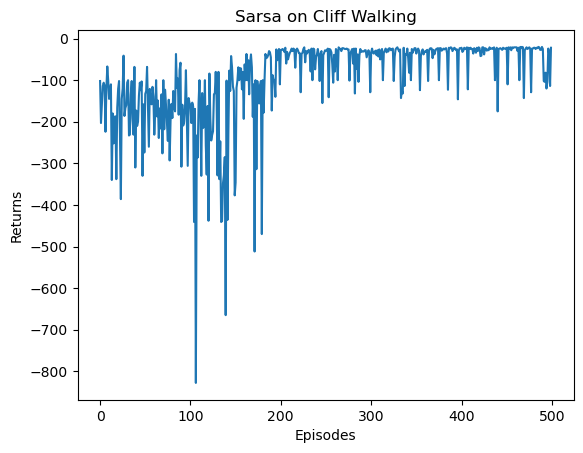

In [7]:
bot.print_epi()

In [8]:
def draw_agent(agent, *, action_meaning=['^', 'v', '<', '>']):
    agent.Pi = agent.get_Pi()
    fig, ax = plt.subplots(figsize=(10, 10))
    k = agent.env.ncol
    action_arrows = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Adjusting for the flipped y-axis
    
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            if agent.env.iscliff(i, j):
                ax.text(j, i, "****", ha='center', va='center', color='red')
            elif agent.env.isend(i, j):
                ax.text(j, i, "EEEE", ha='center', va='center', color='green')
            else:
                a = agent.Pi[i * k + j]
                for idx, prob in enumerate(a):
                    if prob > 0:  # Assuming deterministic policy
                        dx, dy = action_arrows[idx]
                        ax.arrow(j, i, dx * 0.3, dy * 0.3, head_width=0.2, head_length=0.2)

    ax.set_xticks(np.arange(0, agent.env.ncol, 1))
    ax.set_yticks(np.arange(0, agent.env.nrow, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Inverting the y-axis for correct representation
    plt.show()

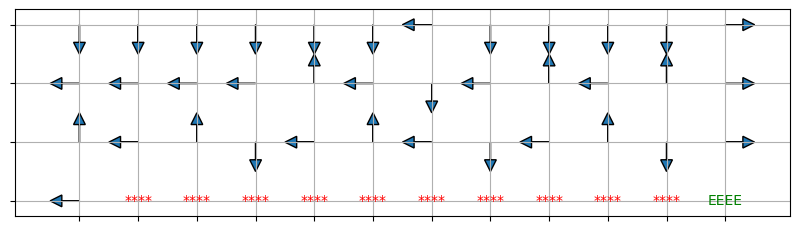

In [9]:
draw_agent(bot)

In [10]:
def print_agent(agent,*, action_meaning=['^', 'v', '<', '>']):
    agent.Pi = agent.get_Pi()
    print("状态价值：")
    k = agent.env.ncol
    print("策略：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            if agent.env.iscliff(i,j) :
                print('****', end=' ')
            elif agent.env.isend(i,j) :  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.Pi[i * k + j]
                pi_str = ''
                for ij in range(len(action_meaning)):
                    pi_str += action_meaning[ij] if a[ij] > 0 else 'o'
                print(pi_str, end=' ')
        print()     

In [11]:
print_agent(bot)

状态价值：
策略：
ovoo ovoo ovoo ovoo ovoo ovoo oo<o ovoo ovoo ovoo ovoo ooo> 
oo<o oo<o oo<o oo<o ^ooo oo<o ovoo oo<o ^ooo oo<o ^ooo ooo> 
^ooo oo<o ^ooo ovoo oo<o ^ooo oo<o ovoo oo<o ^ooo ovoo ooo> 
oo<o **** **** **** **** **** **** **** **** **** **** EEEE 
